In [1]:
using Random
using Distributions

using PyPlot; PyPlot.svg(true)

true

In [2]:
include("../targets.jl")
include("../eigenvi.jl")

include("../variational_families.jl")
include("../polynomials.jl")
include("../sample.jl")

fontsize = 16

Random.seed!(1111)

TaskLocalRNG()

In [3]:
# Use the normalized Hermite variational family
basis_fn = NHP
d_basis_fn = DNHP

DNHP (generic function with 1 method)

In [4]:
# Construct target distribution
distn = MixtureModel(Normal[
   Normal(-2, 0.3),
   Normal(0.0, 0.3),
   Normal(2, 0.3)], 
        [0.3, 0.6, 0.1])

#distn = Normal(0,1)

P(x) = Distributions.pdf(distn, x)
logP(x) = Distributions.logpdf(distn, x)
# score function
dlogP(x) = ForwardDiff.derivative(logP, x)

dlogP (generic function with 1 method)

In [5]:
N = 10_000
sampling_dist = Normal(0, 4)
logPi(x) = Distributions.logpdf(sampling_dist, x)
Z = rand(sampling_dist, N);


In [6]:
# Fit variational approximation
K = 15
α, W, evals = eigenVI_1D(K, Z, dlogP, basis_fn, d_basis_fn; logPi=logPi);

# Construction variational distribution using the fitted α above
Q(x) = q(x, α, K, NHP)

Q (generic function with 1 method)

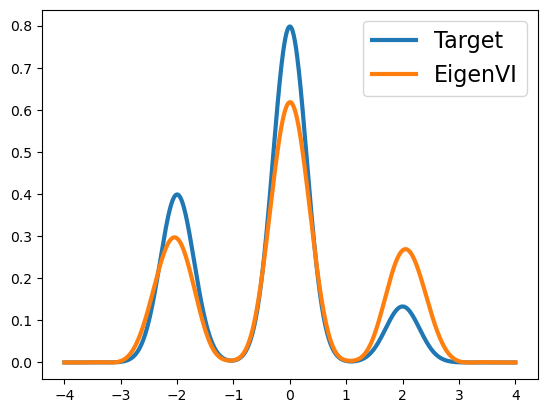

PyObject <matplotlib.legend.Legend object at 0x165e62e60>

In [7]:
Xrange = -4:0.01:4


plot(Xrange, exp.(logP.(Xrange)), label="Target", lw=3)
plot(Xrange, Q.(Xrange), label="EigenVI", lw=3)

#plot(Z, zeros(N))

legend(fontsize=fontsize)

In [8]:
N_samples = 1000

# Samples from P
true_samples = rand(distn, N_samples);

# Samples from Q
samples = sample_q_1D_approx(N_samples, Q, -6., 6., 1000);

1000


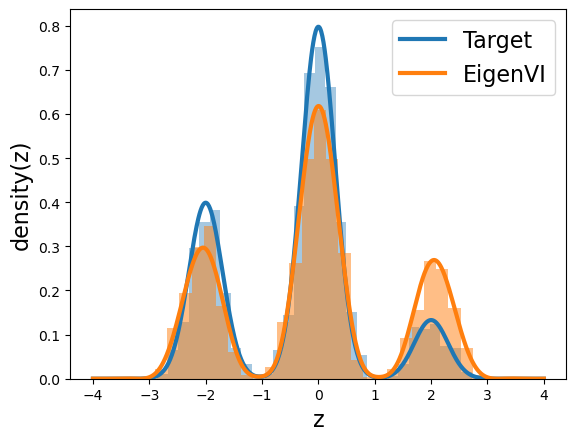

In [9]:
Xrange = -4:0.01:4

plot(Xrange, exp.(logP.(Xrange)), label="Target", lw=3)
plot(Xrange, Q.(Xrange), label="EigenVI", lw=3)
legend(fontsize=fontsize)
xlabel("z", fontsize=fontsize); ylabel("density(z)", fontsize=fontsize)

hist(true_samples, density=true, bins=30, color="tab:blue", alpha=0.4)
hist(samples, density=true, bins=30, color="tab:orange", alpha=0.5);

## Batch and match  

In [10]:
λ(t) = 10/(t+1)
T = 2000
B = 30
D = 1

using ReverseDiff
dlogP_vector(x) = ReverseDiff.gradient(logP, x) 

μ_iterates, Σ_iterates = bam(T, B, zeros(D), ones(D,D), λ, dlogP_vector; tol=1e-8)
μ_fit = μ_iterates[end]
Σ_fit = Σ_iterates[end]

1×1 Matrix{Float64}:
 0.09155888857035097

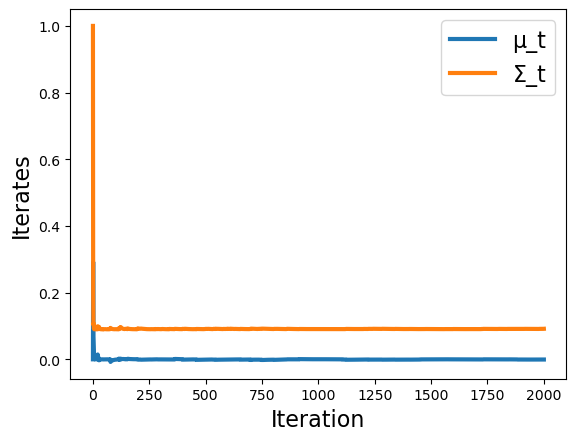

PyObject <matplotlib.legend.Legend object at 0x336212e90>

In [11]:
plot(μ_iterates, label="μ_t", lw=3)
plot([Σ_iterates[t][1,1] for t in 1:length(Σ_iterates)], label="Σ_t", lw=3)

xlabel("Iteration", fontsize=fontsize); ylabel("Iterates", fontsize=fontsize); legend(fontsize=fontsize)

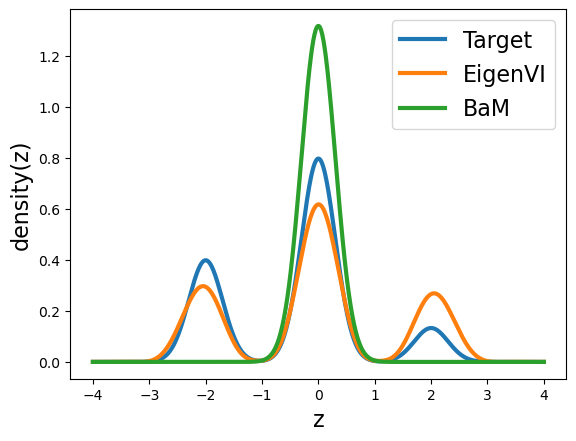

PyObject Text(33.00000000000001, 0.5, 'density(z)')

In [12]:
Xrange = -4:0.01:4

plot(Xrange, exp.(logP.(Xrange)), label="Target", lw=3)
plot(Xrange, Q.(Xrange), label="EigenVI", lw=3)
plot(Xrange, [pdf(MvNormal(μ_fit, Σ_fit), Array([x])) for x in Xrange], lw=3, label="BaM")

legend(fontsize=fontsize)

xlabel("z", fontsize=fontsize); ylabel("density(z)", fontsize=fontsize)